In [1]:
import numpy as np
import pandas as pd
import json
import re
import jieba
from gensim.models import Word2Vec
import gensim
import multiprocessing
from gensim.corpora.dictionary import Dictionary
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional,LSTM,Dense,Embedding,Dropout,Activation,Softmax,Flatten,Conv1D, SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pypinyin import pinyin, lazy_pinyin, Style
from keras.regularizers import l2
import os


plt.rcParams['figure.dpi'] = 1200
plt.rcParams['savefig.dpi'] = 1200
plt.rcParams['font.family'] = ['Heiti TC']

## 清理基金数据
- 读取数据
- 合并年份

In [8]:
# mac 
#project_dir = "/Users/yansong/Library/CloudStorage/Dropbox/nutstore_files/基金研究/"

#imac 
project_dir = "/Users/yansong/Dropbox/nutstore_files/基金研究/"


In [9]:
def nsfc_data(year):
    
    sub_dir = "data/2013_2022面青/"    
    file_name = project_dir+sub_dir+year+".xlsx"
    
    apps = pd.read_excel(file_name,sheet_name = "申请")
    if year in ["2013","2014","2015","2017","2018","2019","2020","2021"]:
        apps.drop(columns=['Unnamed: 0','Unnamed: 5', 'Unnamed: 6','Unnamed: 7', 'Unnamed: 8','项目名称2','姓名','申请单位'],inplace=True)
    elif year == "2016":
        apps.drop(columns=['Unnamed: 0','Unnamed: 5','Unnamed: 7','姓名','申请单位'],inplace=True)
    elif year == "2022":
        apps.drop(columns=['申请单位'],inplace=True)
    else:
        year = []

    apps_comments = apps["反馈评议意见"].str.split("<", expand = True)
    df_app = pd.merge(apps, apps_comments, left_index=True, right_index=True)
    df_app.drop(columns=0,inplace=True)
    df_app.rename(columns={1: "意见1",2: "意见2",3: "意见3",4: "意见4",5: "意见5",6: "意见6"},inplace=True)
    df_app.drop(columns="反馈评议意见",inplace=True)

    df_app.rename(columns={'Unnamed: 2':'申请代码'},inplace=True)
    
    grants = pd.read_excel(file_name,sheet_name = "立项")
    print(grants.shape)
    grants_comments = grants["反馈评议意见"].str.split("<", expand = True)
    grants_comments.drop(columns=0,inplace=True)
    grants_comments.rename(columns={1: "意见1",2: "意见2",3: "意见3",4: "意见4",5: "意见5"},inplace=True)
    df_grants = pd.merge(grants, grants_comments, left_index=True, right_index=True)
    df_grants.drop(columns="反馈评议意见",inplace=True)

    df_app["立项"] = 0
    df_length = df_app.shape[0]
    for i in range(df_length):
        app_name = df_app["项目名称"][i]
        df_app.loc[i,"立项"] = df_grants["项目名称"].isin([app_name]).sum()
    return df_app

In [10]:
df_2022 = nsfc_data("2022")
df_2022.rename(columns={"资助类别_x":"资助类别"},inplace=True)
df_2022.rename(columns={"申请代码1":"申请代码"},inplace=True)
df_2021 = nsfc_data("2021")
df_2020 = nsfc_data("2020")
df_2019 = nsfc_data("2019")
df_2018 = nsfc_data("2018")
df_2017 = nsfc_data("2017")
df_2016 = nsfc_data("2016")
df_2015 = nsfc_data("2015")
df_2014 = nsfc_data("2014")
df_2013 = nsfc_data("2013")

columns = ['项目名称','申请代码', '申请人', '申请部门', '资助类别', '意见1', '意见2', '意见3', '意见4', '意见5','立项']

df_22 = df_2022[columns]
df_22 = df_22.assign(年份=2022)

df_21 = df_2021[columns]
df_21 = df_21.assign(年份=2021)

df_20 = df_2020[columns]
df_20 = df_20.assign(年份=2020)

df_19 = df_2019[columns]
df_19 = df_19.assign(年份=2019)

df_18 = df_2018[columns]
df_18 = df_18.assign(年份=2018)

df_17 = df_2017[columns]
df_17 = df_17.assign(年份=2017)

df_16 = df_2016[columns]
df_16 = df_16.assign(年份=2016)

df_15 = df_2015[columns]
df_15 = df_15.assign(年份=2015)

df_14 = df_2014[columns]
df_14 = df_14.assign(年份=2014)

df_13 = df_2013[columns]
df_13 = df_13.assign(年份=2013)

df_all = pd.concat([df_22,df_21,df_20,df_19,df_18,df_17,df_16,df_15,df_14,df_13])

qn_all = df_all[df_all['资助类别']=="青年科学基金项目"]
ms_all = df_all[df_all['资助类别']=="面上项目"]

qn_all = qn_all.sort_values(['年份','申请人']).reset_index()

(354, 11)
(311, 8)
(307, 8)
(296, 8)
(225, 8)
(253, 8)
(194, 8)
(229, 8)
(206, 8)
(218, 8)


In [11]:
df_all['年份'].value_counts()

年份
2022    1186
2021    1180
2020    1050
2019     895
2018     657
2013     621
2017     604
2016     589
2015     581
2014     533
Name: count, dtype: int64

In [12]:
qn_all['年份'].value_counts()

年份
2022    582
2021    547
2020    439
2019    345
2013    217
2018    212
2014    209
2017    205
2016    204
2015    178
Name: count, dtype: int64

In [13]:
ms_all['年份'].value_counts()

年份
2021    633
2020    611
2022    604
2019    550
2018    445
2013    404
2015    403
2017    399
2016    385
2014    324
Name: count, dtype: int64

In [14]:
qn_all.head(1)

,index,项目名称,申请代码,申请人,申请部门,资助类别,意见1,意见2,意见3,意见4,意见5,立项,年份
0,86,济南地区大气颗粒物中多环芳烃分布规律与污染源调查,B0603,丁磊,NaN,青年科学基金项目,1>该项目拟研究济南地区大气颗粒物中多环芳烃分布规律。尽管大气颗粒物中多环芳烃分布是一重要研...,2>大气颗粒物中PAHs相关研究已有很多，申请者对相关研究进展和前沿把握不是很清楚，研究内容...,3> 多环芳烃（PAHs）在大气、水体、土壤等环境介质中广泛存在，具有致癌、致畸、致突变等特...,None,None,0,2013


### 输出申请人姓名拼音数据--青年

In [15]:
applicants = qn_all['申请人']

In [16]:
applicants_pinyin = []
for i in applicants:
    applicants_pinyin.append(lazy_pinyin(i))
print(len(applicants_pinyin))
applicants_py = []

for i in applicants_pinyin:
    if len(i) == 3:
        capitalized = [str.capitalize(i[0]),str.capitalize(i[1]+i[2])]
        applicants_py.append(capitalized)
    elif len(i) == 2:
        capitalized = [str.capitalize(i[0]),str.capitalize(i[1])]
        applicants_py.append(capitalized)
    else:
        print(i)
        applicants_py.append(i)


3138
['Bagrat Mailyan']
['Tsona Tchinda Narcisse']
['Shani Tiwari']
['Munish Kumar Gupta']
['LIU YI']
['Najib Ahmad Muhammad']
['LIU YI']
['WU SHU YAO']


In [17]:
qn_all['py']= applicants_py

In [18]:
qn_all.head(1)

,index,项目名称,申请代码,申请人,申请部门,资助类别,意见1,意见2,意见3,意见4,意见5,立项,年份,py
0,86,济南地区大气颗粒物中多环芳烃分布规律与污染源调查,B0603,丁磊,NaN,青年科学基金项目,1>该项目拟研究济南地区大气颗粒物中多环芳烃分布规律。尽管大气颗粒物中多环芳烃分布是一重要研...,2>大气颗粒物中PAHs相关研究已有很多，申请者对相关研究进展和前沿把握不是很清楚，研究内容...,3> 多环芳烃（PAHs）在大气、水体、土壤等环境介质中广泛存在，具有致癌、致畸、致突变等特...,None,None,0,2013,"[Ding, Lei]"


In [19]:
sub_dir = "data/2013_2022面青/applicants_py.csv"
file_name = project_dir+sub_dir
pd.DataFrame(applicants_py).to_csv(file_name,encoding='utf_8_sig')

In [20]:
sub_dir = "data/2013_2022面青/qn_all.csv"
file_name = project_dir+sub_dir
pd.DataFrame(qn_all).to_csv(file_name,encoding='utf_8_sig')

### 输出申请人姓名拼音数据-面上

In [21]:
applicants = ms_all['申请人'].unique()

applicants_pinyin = []
for i in applicants:
    applicants_pinyin.append(lazy_pinyin(i))
print(len(applicants_pinyin))
applicants_py = []

for i in applicants_pinyin:
    if len(i) == 3:
        capitalized = [str.capitalize(i[0]),str.capitalize(i[1]+i[2])]
        applicants_py.append(capitalized)
    elif len(i) == 2:
        capitalized = [str.capitalize(i[0]),str.capitalize(i[1])]
        applicants_py.append(capitalized)
    else:
        print(i)

1947
['du', 'yang', 'hong', 'yue']
['Tsona Tchinda Narcisse']
['Timo Pitknen']
['Motoharu Nowada']
['ALEXANDER DEGELING']
['Kaufmann']
['Jong-Sun Park']
['Balan Nanan']
['XU GUANGWU']
['Jeongwoo Lee']
['Rolf Müller']
['Abdelwahid MELLOUKI']
['Hartmut Günter Dr. Herrmann']
['Hiroshi Rikimaru']
['DONG MING WANG']
['Rolf Mueller']


In [22]:
ms_all.head(1)

,项目名称,申请代码,申请人,申请部门,资助类别,意见1,意见2,意见3,意见4,意见5,立项,年份
1,Rankin-Selberg L-函数在weight方面的双重均值估计,A0102,孙海伟,威海校区,面上项目,1>具体评价意见：\n一、该申请项目的研究内容是否具有原创性并值得鼓励尝试？请针对创新点（如...,2>具体评价意见：\n一、该申请项目的研究内容是否具有原创性并值得鼓励尝试？请针对创新点（如...,3>具体评价意见：\n一、该申请项目的研究内容是否具有原创性并值得鼓励尝试？请针对创新点（如...,4>具体评价意见：\n一、该申请项目的研究内容是否具有原创性并值得鼓励尝试？请针对创新点（如...,5>具体评价意见：\n一、该申请项目的研究内容是否具有原创性并值得鼓励尝试？请针对创新点（如...,0,2022


In [23]:
sub_dir = "data/2013_2022面青/ms_all.csv"
file_name = project_dir+sub_dir
pd.DataFrame(ms_all).to_csv(file_name,encoding='utf_8_sig')

sub_dir = "data/2013_2022面青/ms_applicants_py.csv"
file_name = project_dir+sub_dir
pd.DataFrame(applicants_py).to_csv(file_name,encoding='utf_8_sig')

## 描述性数据

### 1. 分申请代码的成功率

In [24]:
qn_all = qn_all.copy()
ms_all = ms_all.copy()

qn_all['申请类别'] = qn_all['申请代码'].str.get(0)
ms_all['申请类别'] = ms_all['申请代码'].str.get(0)

qn_all['申请类别'].replace('A','理工',inplace=True)
qn_all['申请类别'].replace('B','理工',inplace=True)
qn_all['申请类别'].replace('C','理工',inplace=True)
qn_all['申请类别'].replace('D','理工',inplace=True)
qn_all['申请类别'].replace('E','理工',inplace=True)
qn_all['申请类别'].replace('F','理工',inplace=True)
qn_all['申请类别'].replace('G','管理',inplace=True)
qn_all['申请类别'].replace('H','医学',inplace=True)

ms_all['申请类别'].replace('A','理工',inplace=True)
ms_all['申请类别'].replace('B','理工',inplace=True)
ms_all['申请类别'].replace('C','理工',inplace=True)
ms_all['申请类别'].replace('D','理工',inplace=True)
ms_all['申请类别'].replace('E','理工',inplace=True)
ms_all['申请类别'].replace('F','理工',inplace=True)
ms_all['申请类别'].replace('G','管理',inplace=True)
ms_all['申请类别'].replace('H','医学',inplace=True)

qn_plot = qn_all.groupby(['申请类别','年份']).立项.mean().reset_index()
ms_plot = ms_all.groupby(['申请类别','年份']).立项.mean().reset_index()

In [25]:
# #fig, ax = plt.subplots(figsize=(8,6))
# fig, ax = plt.subplots(figsize=(4,3))
# scatter = ax.scatter( qn_plot.年份, qn_plot.立项,c = pd.Categorical(qn_plot.申请类别).codes, cmap='tab20b')
# sp_names = ['理工类','管理类']
# plt.legend(handles=scatter.legend_elements()[0], 
#            labels=sp_names,
#            loc='upper right',
#            title="")
# plt.savefig('/Users/yansong/Nutstore_Files/基金研究/graph_updated/青年科学基金资助率.png')
# plt.show()


In [26]:
# fig, ax = plt.subplots(figsize=(8,6))
# ax.scatter(ms_plot.年份, ms_plot.立项,c = pd.Categorical(ms_plot.申请类别).codes, cmap='tab20b')
# sp_names = ['STEM','Management']
# plt.legend(handles=scatter.legend_elements()[0], 
#            labels=sp_names,
#            loc='upper right',
#            title="")
# plt.show()
# plt.show()

In [27]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [28]:
# nsfc_all = pd.concat([qn_all,ms_all])
# nsfc_plot = nsfc_all.groupby(['申请类别','年份']).立项.mean().reset_index()


# matplotlib.style.use('bmh') 

# fig, ax = plt.subplots(figsize=(8,6))
# ax.scatter(nsfc_plot.年份, nsfc_plot.立项,c = pd.Categorical(nsfc_plot.申请类别).codes, cmap='tab20b')
# sp_names = ['STEM','Management']
# plt.legend(handles=scatter.legend_elements()[0], 
#            labels=sp_names,
#            loc='upper right',
#            title="")
# plt.show()
# plt.show()

### 2.平均申请次数

In [29]:
qn_all.sort_values(['申请人','年份']).head(1)

,index,项目名称,申请代码,申请人,申请部门,资助类别,意见1,意见2,意见3,意见4,意见5,立项,年份,py,申请类别
217,221,与磁层高纬太阳风进入相关的极光研究,D0411,Bagrat Mailyan,威海校区,青年科学基金项目,1>该项目研究行星际磁场北向时，跨极区极光弧与高纬重联产生的太阳风进入区之间的关系，选题有一...,2>一、揭示在不同行星际条件下太阳风进入磁层和地球空间的路径、方式和效应，是日地物理和空间天...,3>此项目拟综合运用极光成像观测和极区沉降粒子观测，探讨高纬尾瓣等离子体与极光之间联系，分析...,None,None,1,2014,[Bagrat Mailyan],理工


In [30]:
qn_all['success'] =  qn_all.groupby(['申请人']).立项.transform('max')

In [31]:
# qn_count = qn_all[qn_all['success']==1].groupby(['申请人']).立项.count().reset_index()
# matplotlib.style.use('bmh') 
# qn_count.立项.value_counts(normalize=True).plot.bar()
# plt.xlabel("申请成功所需次数")
# plt.savefig('/Users/yansong/Nutstore_Files/基金研究/graph_updated/申请成功所需次数.png')
# plt.show

## ML 模型预测申请成功与否

In [33]:
text = "我爱自然语言处理"
tokens = jieba.cut(text)
print(" ".join(tokens))

我 爱 自然语言 处理


### 处理申请意见

In [34]:
df_all.reset_index(inplace=True)

df_all["id"] = df_all.index

df_json = df_all[['id',"意见1","意见2","意见3","意见4","意见5","立项"]].copy()

duplicate_counts = df_json["id"].value_counts()
duplicates = duplicate_counts[duplicate_counts > 1]

# Generating the report
report = pd.DataFrame({'Value': duplicates.index, 'Count': duplicates.values})

report = pd.DataFrame({'Value': duplicates.index, 'Count': duplicates.values})

# Display the report
print(report)

# transform from wide to long 
df_json_long = pd.wide_to_long(df_json, stubnames='意见', i=['id'], j='评审')
df_json_long.reset_index(inplace=True)
df_json_long.rename(columns={"立项":"records","意见":"content"},inplace=True)
df_json_long.dropna(inplace=True)
df_json_long.sort_values(['id'])
df_json_long["records"].replace(to_replace=0, value="负",inplace=True)
df_json_long["records"].replace(to_replace=1, value="正",inplace=True)
df_json_long = df_json_long[["id","records","content"]]

sample_size = df_json_long.shape[0]

df_json_sample = df_json_long.iloc[0:sample_size,:]
result = df_json_sample.to_json(orient="index",force_ascii=False)

with open('data.json', 'w') as f:
    json.dump(result,f,ensure_ascii=False)
    
df_json_sample.head()

Empty DataFrame
Columns: [Value, Count]
Index: []


,id,records,content
0,0,负,1>具体评价意见：\n一、该申请项目的研究思想或方案是否具有新颖性和独特性？请详细阐述判断理...
1,1,负,1>具体评价意见：\n一、该申请项目的研究内容是否具有原创性并值得鼓励尝试？请针对创新点（如...
2,2,正,1>具体评价意见：\n一、该申请项目的研究内容是否具有原创性并值得鼓励尝试？请针对创新点（如...
3,3,负,1>具体评价意见：\n一、该申请项目的研究思想或方案是否具有新颖性和独特性？请详细阐述判断理...
4,4,负,1>具体评价意见：\n一、该申请项目的研究思想或方案是否具有新颖性和独特性？请详细阐述判断理...


In [35]:
def clean_pat(line):
    pat = ['一、该申请项目所关注的科学问题是否源于多学科领域交叉的共性问题，具有明确的学科交叉特征？请详细阐述判断理由并评价预期成果的科学价值。',
          '二、请针对学科交叉特点评述申请项目研究方案或技术路线的创新性和可行性。',
          '三、请评述申请人的多学科背景、研究专长和创新潜力。',
          '四、其他建议',
          '1>',
          '（1）',
          '（2）',
          '（3）',
          '（4）',
          '（5）',
           '具体评价意见：',
          '一、该申请项目的研究思想或方案是否具有新颖性和独特性？请详细阐述判断理由。',
          '二、请评述申请项目所关注问题的科学价值以及对相关前沿领域的潜在贡献。',
          '三、请评述申请人的创新潜力与研究方案的可行性',
          '一、该申请项目是否面向国家需求并试图解决技术瓶颈背后的基础问题？请结合应用需求详细阐述判断理由。',
          '二、请评述申请项目所提出的科学问题与预期成果的科学价值。',
          '三、请评述申请人的创新潜力及研究方案的创新性和可行性。',
          '。',
          '，',
          '、',
          '的',
          '研究',
          '三请',
          '申请人',
          '拟']

    line = re.sub("\n", "", line)
    
    for x in pat:
        line = re.sub(x, "", line)
    
    # stopwords
    sub_dir = "data/stopwords.txt"
    file_name = project_dir+sub_dir
    stopwords=pd.read_csv(file_name, header=None)[0].tolist() 
    for x in stopwords:
        line = re.sub(x, "", line)
    return line

In [36]:
df_json_sample["content_clean"] = df_json_sample["content"].apply(clean_pat)

/var/folders/kp/gk4kvr5s0plbp5y3112cx_x00000gn/T/ipykernel_8451/237222752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_json_sample["content_clean"] = df_json_sample["content"].apply(clean_pat)


In [37]:
df_json_sample["content_clean"][0]

'事方解析数模仿FeigonWhitehouse2009年开创性工作借助相迹公式二人均值公式推广全实域上Hilbert尖形式上进出应L-函数中心值非零性后类似方法二次扩域上Asai L-函数类更高阶L-函数均值公式计划定科学价值颇难度思想新颖性独特性稍显整申请书人感觉搬人方法缺乏独特思想事实上采FeigonWhitehouse2009年提出方法解决更困难需更高级技巧工具阐述缺乏说服力申请项目关注定科学价值计划够利相关领域会定2020年获博士学位尚未文发表两篇文投稿现工作创新潜力正指出采FeigonWhitehouse2009年提出方法解决更困难需更高级技巧工具阐述缺乏说服力极大影响方案行性判断1. 申请青年基金不需工作积累还需干份量工作建议代表作发表后再申请青年基金样会更说服力极大提高申请成功率2. 刚毕业缺乏写作验建议验前辈请教便提高申请书读性说服力进提高申请成功率3. 申请书19页倒数2行应“晨兴数学中心”'

### 使用jieba进行分词

In [38]:
seg_lists = list()
sentences = []

lines = list(df_json_sample['content_clean'])
for line in lines:
    seg_lists.append(jieba.cut(line))
for i in seg_lists:      
    sentences.append(' '.join(i))    
print(sentences[0])

事方 解析 数 模仿 FeigonWhitehouse2009 年 开创性 工作 借助 相迹 公式 二人 均值 公式 推广 全实域 上 Hilbert 尖 形式 上 进出 应 L - 函数 中心 值非 零性 后 类似 方法 二次 扩域 上 Asai   L - 函数 类 更 高阶 L - 函数 均值 公式 计划 定 科学 价值 颇 难度 思想 新颖性 独特性 稍 显整 申请书 人 感觉 搬人 方法 缺乏 独特 思想 事实上 采 FeigonWhitehouse2009 年 提出 方法 解决 更 困难 需 更 高级 技巧 工具 阐述 缺乏 说服力 申请 项目 关注 定 科学 价值 计划 够利 相关 领域 会定 2020 年 获 博士学位 尚未 文 发表 两篇 文 投稿 现 工作 创新 潜力 正 指出 采 FeigonWhitehouse2009 年 提出 方法 解决 更 困难 需 更 高级 技巧 工具 阐述 缺乏 说服力 极大 影响 方案 行性 判断 1 .   申请 青年 基金 不需 工作 积累 还 需干 份量 工作 建议 代表作 发表 后 再 申请 青年 基金 样会 更 说服力 极大 提高 申请 成功率 2 .   刚 毕业 缺乏 写作 验 建议 验 前辈 请教 便 提高 申请书 读性 说服力 进 提高 申请 成功率 3 .   申请书 19 页 倒数 2 行应 “ 晨兴 数学 中心 ”


In [39]:
# 生成每个意见对应的sentiment为正面或者负面
labels = df_json_sample["records"].copy()
labels.replace("负",0,inplace=True)
labels.replace("正",1,inplace=True)
labels = list(labels)

In [40]:
# # Plot wordcloud
# texts = ''.join(map(str, sentences))
# wordcloud = WordCloud(font_path = '/System/Library/Fonts/STHeiti Light.ttc',
#             background_color="white",# 设置背景颜色
#            max_words=80, # 词云显示的最大词数
#            height=400, # 图片高度
#            width=800, # 图片宽度
#            max_font_size=50).generate(texts)
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")

In [41]:
vocab_size = 20000 #估计的词汇表大小，设置时要比真实的词汇量大，不然会产生不同单词分配了相同的索引。

# #通过索引对上面句子进行编码，one_hot编码映射到[1,vocab_size]，不包括0
# encoded_docs = [one_hot(s, vocab_size) for s in sentences]
# # 文本编码成数字格式并padding到相同长度，这里长度设置为4，在后面补0，这也是为什么前面one-hot不会映射到0的原因。

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(sentences)
encoded_docs = tokenizer.texts_to_sequences(sentences)
max_length = 200
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [42]:
sentences[0]

'事方 解析 数 模仿 FeigonWhitehouse2009 年 开创性 工作 借助 相迹 公式 二人 均值 公式 推广 全实域 上 Hilbert 尖 形式 上 进出 应 L - 函数 中心 值非 零性 后 类似 方法 二次 扩域 上 Asai   L - 函数 类 更 高阶 L - 函数 均值 公式 计划 定 科学 价值 颇 难度 思想 新颖性 独特性 稍 显整 申请书 人 感觉 搬人 方法 缺乏 独特 思想 事实上 采 FeigonWhitehouse2009 年 提出 方法 解决 更 困难 需 更 高级 技巧 工具 阐述 缺乏 说服力 申请 项目 关注 定 科学 价值 计划 够利 相关 领域 会定 2020 年 获 博士学位 尚未 文 发表 两篇 文 投稿 现 工作 创新 潜力 正 指出 采 FeigonWhitehouse2009 年 提出 方法 解决 更 困难 需 更 高级 技巧 工具 阐述 缺乏 说服力 极大 影响 方案 行性 判断 1 .   申请 青年 基金 不需 工作 积累 还 需干 份量 工作 建议 代表作 发表 后 再 申请 青年 基金 样会 更 说服力 极大 提高 申请 成功率 2 .   刚 毕业 缺乏 写作 验 建议 验 前辈 请教 便 提高 申请书 读性 说服力 进 提高 申请 成功率 3 .   申请书 19 页 倒数 2 行应 “ 晨兴 数学 中心 ”'

In [43]:
len(padded_docs)

32382

In [44]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length))  # Increased embedding dimension
model.add(Bidirectional(LSTM(50, return_sequences=True)))  # Increased LSTM units and added return_sequences=True
model.add(Dropout(0.5))  # Dropout to prevent overfitting
model.add(Bidirectional(LSTM(20)))  # Additional LSTM layer
model.add(Flatten())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.1)))  # Increased regularization
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           1000000   
                                                                 
 bidirectional (Bidirection  (None, 200, 100)          40400     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200, 100)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 40)                19360     
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 4

In [45]:
history = model.fit(padded_docs, np.array(labels),validation_split = 0.6, epochs=10)

Epoch 1/10
405/405 [==============================] - 30s 71ms/step - loss: 0.6310 - accuracy: 0.7315 - val_loss: 0.5779 - val_accuracy: 0.7429
Epoch 2/10
405/405 [==============================] - 29s 71ms/step - loss: 0.5382 - accuracy: 0.7555 - val_loss: 0.4959 - val_accuracy: 0.7837
Epoch 3/10
405/405 [==============================] - 29s 72ms/step - loss: 0.4269 - accuracy: 0.8327 - val_loss: 0.4740 - val_accuracy: 0.7973
Epoch 4/10
405/405 [==============================] - 30s 75ms/step - loss: 0.3258 - accuracy: 0.8938 - val_loss: 0.4885 - val_accuracy: 0.7794
Epoch 5/10
405/405 [==============================] - 31s 76ms/step - loss: 0.2594 - accuracy: 0.9287 - val_loss: 0.5091 - val_accuracy: 0.8081
Epoch 6/10
405/405 [==============================] - 30s 75ms/step - loss: 0.2098 - accuracy: 0.9524 - val_loss: 0.5203 - val_accuracy: 0.8005
Epoch 7/10
405/405 [==============================] - 30s 73ms/step - loss: 0.1942 - accuracy: 0.9572 - val_loss: 0.5656 - val_accuracy:

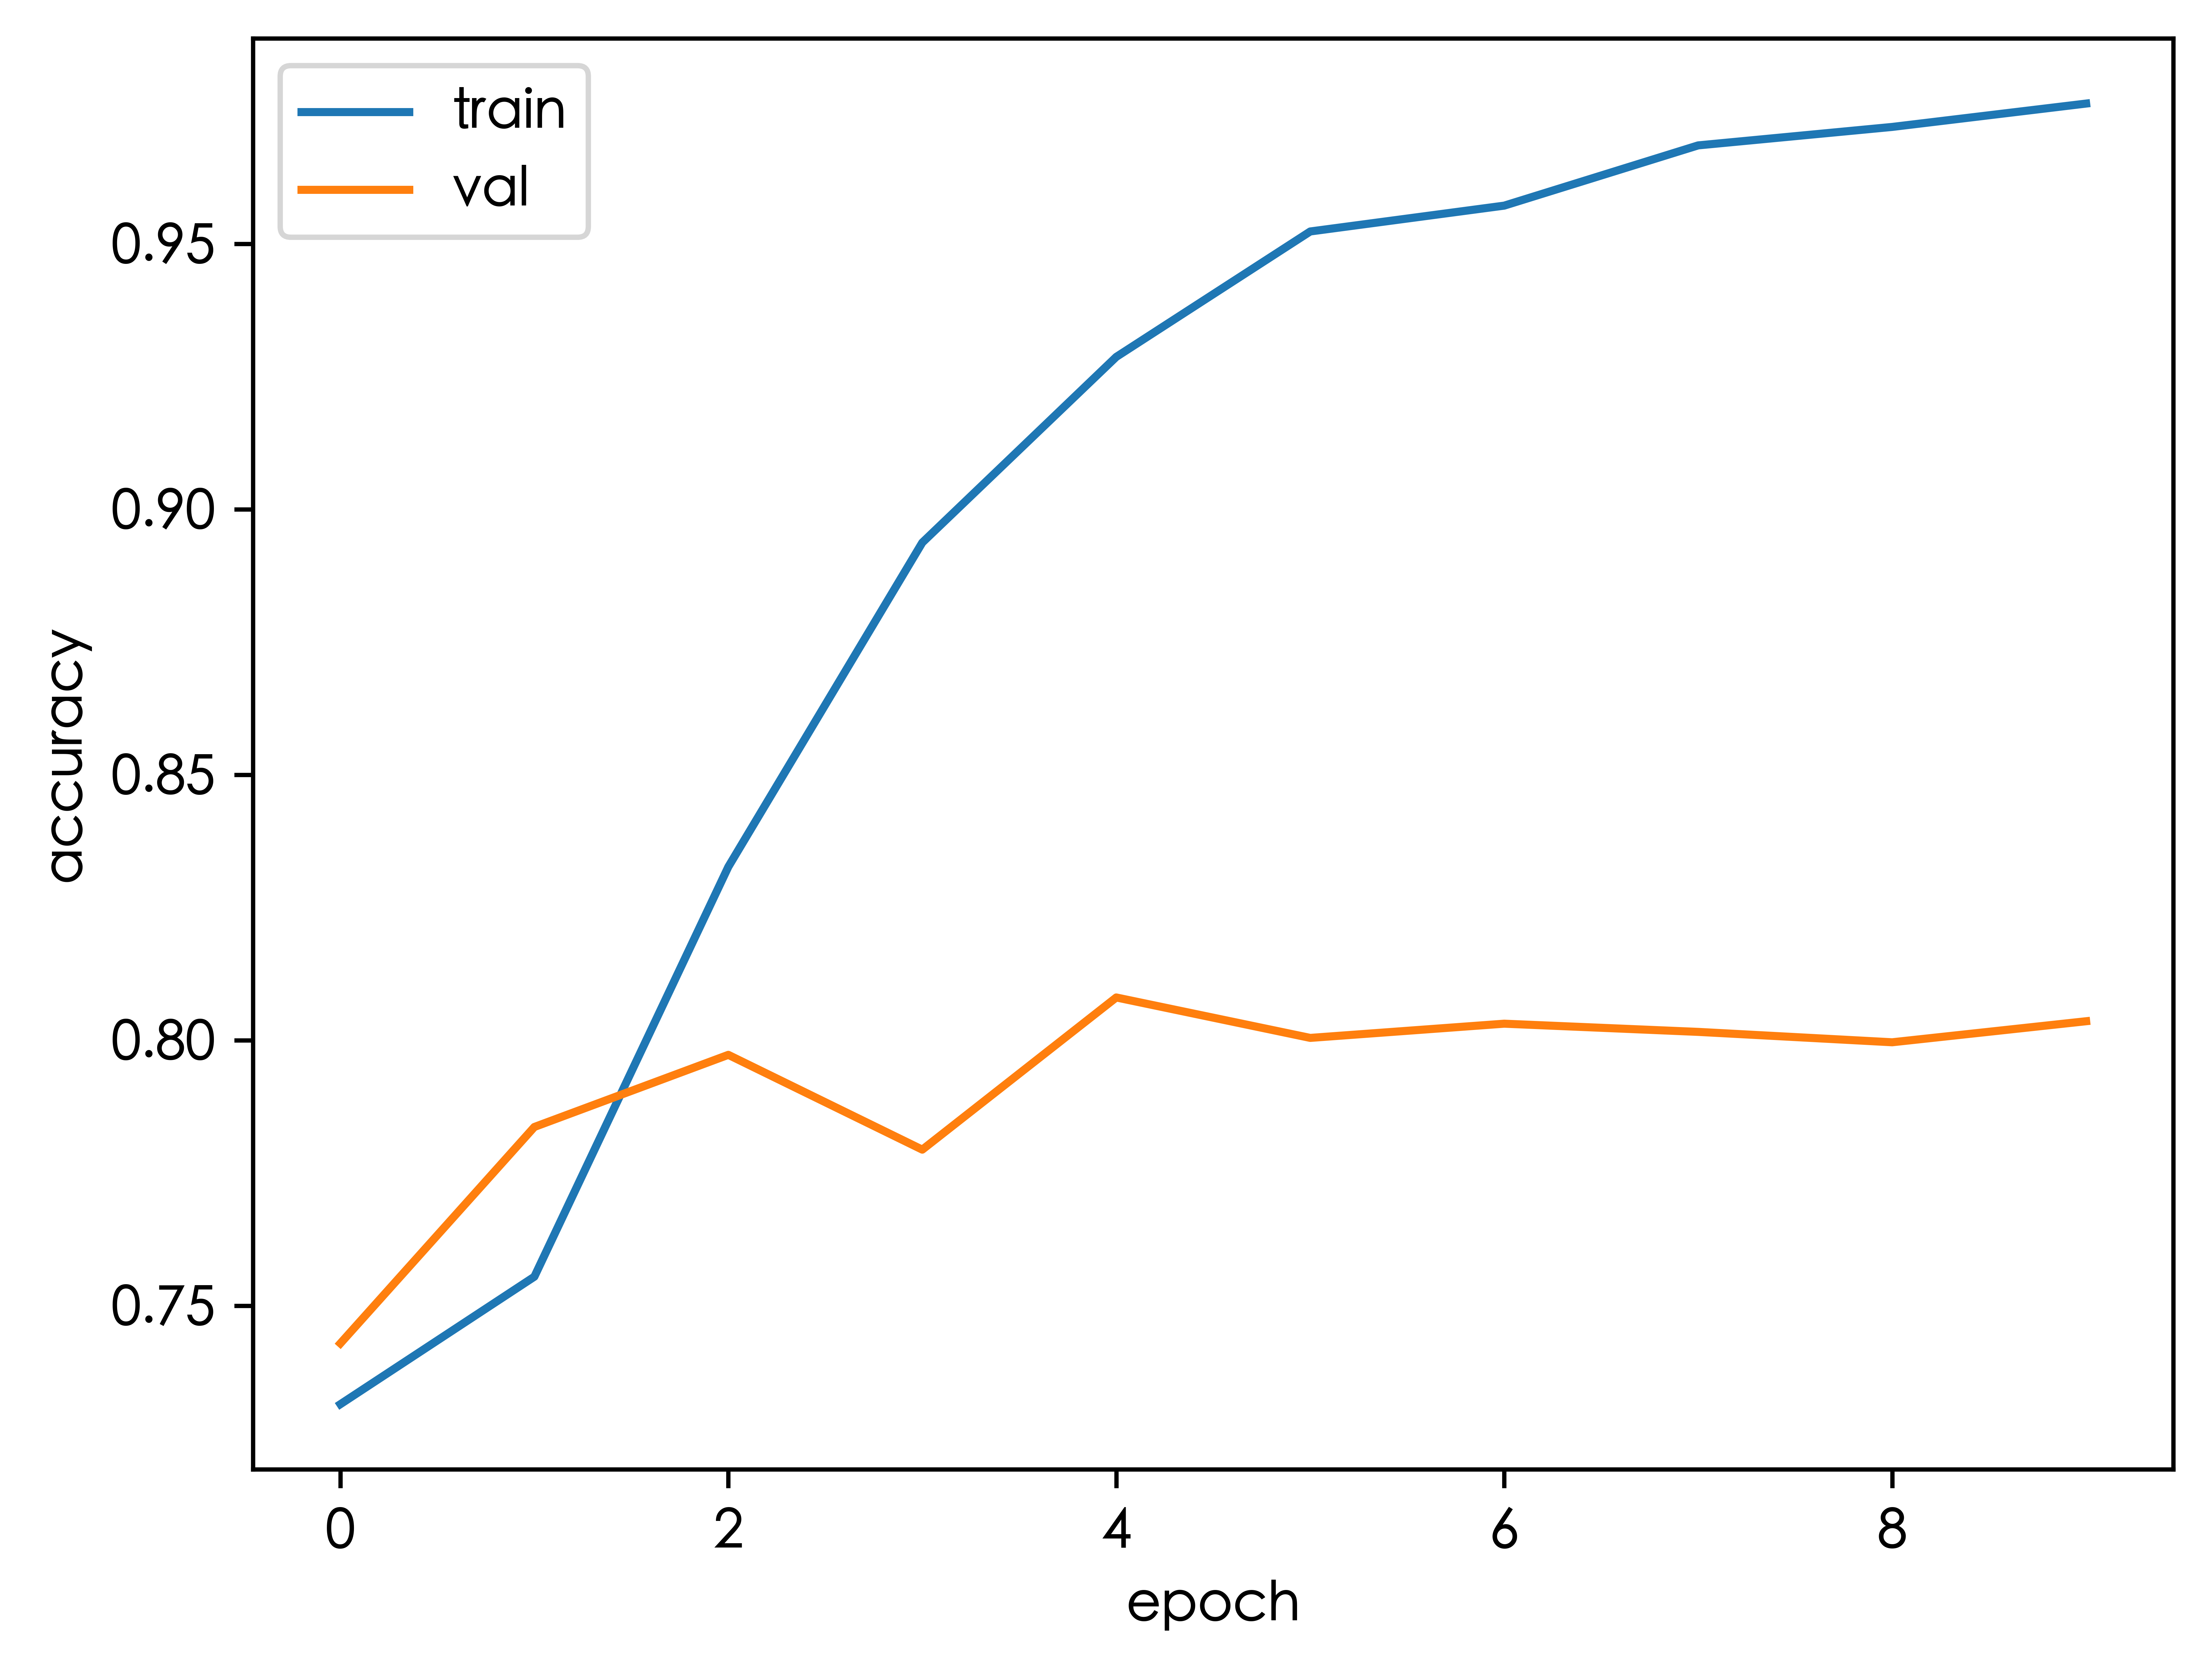

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig('/Users/yansong/Nutstore_Files/基金研究/graph_updated/model_accuracy.png')